# Historical Text Normalization: character-level recurrent sequence-to-sequence model (seq2seq)


Input sequences from Historical English to the target sequences in Modern English.
In order to implement this character-level recurrent sequence-to-sequence model, we need:
* An encoder LSTM
* A decoder LSTM

## Setup: import modules

In [1]:
import numpy as np
import tensorflow as tf #if there are errors: pip3 install tensorflow on anaconda prompt
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import re

## Downloading the data: ICAMET corpus
**
Note: the ICAMET Corpus is divided into **dev**, **test** and **train** sets
<p> The files of the ICAMET Corpus have been converted to text files and they should be stored locally in the same path as the present jupyter notebook </p>


* **Input**: Historical English e.g. "meynteigne"
* **Target**: Normalized form -> Modern English e.g. "maintain"

In [2]:
notebook_path =os.path.abspath('seq2seq.ipynb')
dev_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_dev_en.txt') 
dev_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_dev_hs.txt')
train_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_train_hs.txt')
train_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_train_en.txt') 
test_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_test_hs.txt')
test_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_test_en.txt') 
print(dev_en + '\n' + dev_hs + '\n' + train_en + '\n' + train_hs + '\n' + test_en + '\n' + test_hs)

C:\Users\jolll\Documents\SynologyDrive\uzh\Programming_Project\seq2seq\icamet_en-hs_dev_en.txt
C:\Users\jolll\Documents\SynologyDrive\uzh\Programming_Project\seq2seq\icamet_en-hs_dev_hs.txt
C:\Users\jolll\Documents\SynologyDrive\uzh\Programming_Project\seq2seq\icamet_en-hs_train_en.txt
C:\Users\jolll\Documents\SynologyDrive\uzh\Programming_Project\seq2seq\icamet_en-hs_train_hs.txt
C:\Users\jolll\Documents\SynologyDrive\uzh\Programming_Project\seq2seq\icamet_en-hs_test_en.txt
C:\Users\jolll\Documents\SynologyDrive\uzh\Programming_Project\seq2seq\icamet_en-hs_test_hs.txt


Next step: read the data and save them in variables

In [3]:
#dev set
with open(dev_hs, encoding='utf8') as hs_raw_dev:
    input_dev  = hs_raw_dev.read().split('\n')
with open(dev_en, encoding='utf8') as en_raw_dev:
    target_dev = en_raw_dev.read().split('\n')
#print(target_dev[:10])
print(len(input_dev))

#train set
with open(train_en, encoding='utf8') as en_raw_train:
    target_train = en_raw_train.read().split('\n')
print(target_train[:10])    
with open(train_hs, encoding='utf8') as hs_raw_train:
    input_train = hs_raw_train.read().split('\n')
print(input_train[:10]) #to see how the data looks like
#print(input_train)
print(len(input_train))

#test set
with open(test_en, encoding='utf8') as en_raw_test:
    target_test = en_raw_test.read().split('\n')
#print(target_test[:10])
with open(test_hs, encoding='utf8') as hs_raw_test:
    input_test = hs_raw_test.read().split('\n')
#print(input_test[:10])
print(len(input_test))

16962
['To', 'the', 'most', 'noble', 'and', 'worthiest', 'Lords', 'most', 'rightful', 'and']
['To', 'the', 'moost', 'noble', '&', 'Worthiest', 'Lordes', 'moost', 'ryghtful', '&']
152900
18299


**How does the data look like?** One word per line, without context 

**How many input tokens do the 3 data sets have?** dev set:16'962 /train set: 152'900/test set: 18'299 --> the train set is 10x bigger than the other sets, which makes sense

## Step 1: preprocessing the data
### Lowercasing, padding and punctuation removal

* **Punctuation:** removing punctuation means removing noise (=cleaning the data). Thus, should we remove punctuation? <p> In our Historical English texts, we find many instances where "&" is present and translated into Modern English "and". </p> 
<p> Also, there are abbrevations such as "M." where we can't get rid of the final dot. </p>
<p> - the hyphen is an important punctuation sign that appears often in Historical English, as it is part of the original orthography </p>
<p> Based on these observations, we will remove all other punctuation signs </p>

In [4]:
def clean_data(txt):
    filtered_words = []
    for i in txt:
        x=re.sub(r"[?!\/,\\(@\[){}%°~^\]+£=#$\*\)\"^]","",i)
        filtered_words.append(x)
    return filtered_words
#storing punctuation free text
punct_in_dev = clean_data(input_dev)
punct_out_dev = clean_data(target_dev)
punct_in_train = clean_data(input_train)
punct_out_train = clean_data(target_train)
punct_in_test = clean_data(input_test)
punct_out_test = clean_data(target_test)
#print(punct_in_dev)

In [5]:
#keep for purposes of experimentation
# input_train = [item.replace(r"[?!\/,\\(@\[){}%~^\]+=#$*\"^]", '😊') for item in input_train]
#input_train2 = [item.replace(r'[?!\/,\\(@\[){}%~^\]+=#$\*\"^]', '') for item in input_train]

#mylist=[]
#for i in input_train:
#    x=re.sub(r"[?!\/,\\(@\[){}%~^\]+=#$*\"^]","😊",i)
#    mylist.append(x)
#print(mylist)

* **Lowercasing:** Lowercasing is an important pre-processing step, as we have capitalization at the beginning of the sentence and in particular NE (as in proper nouns)-> for the sake of simplicity
<p> the lower() method turns all characters into lower case </p>

In [6]:
in_dev = [punct_in_dev[i].lower() for i in range(len(punct_in_dev))]
out_dev = [punct_out_dev[i].lower() for i in range(len(punct_out_dev))]
#for i in range(len(input_train)):
#    input_train[i] = input_train[i].lower()
in_train = [punct_in_train[i].lower() for i in range(len(punct_in_train))]
out_train = [punct_out_train[i].lower() for i in range(len(punct_out_train))]

in_test = [punct_in_test[i].lower() for i in range(len(punct_in_test))]
out_test = [punct_out_test[i].lower() for i in range(len(punct_out_test))]

print(len(in_dev))
print(len(in_train))
print(in_dev[10000:10100])

16962
152900
['my', 'la.', 'of', 'roxbrough', 'grows', 'big', 'and', 'lookes', 'her', 'for', 'about', 'the', 'latter', 'ende', 'of', 'the', 'next', 'mont', 'of', 'begineing', 'of', 'december', 'which', 'i', 'fear', 'will', 'draw', 'me', 'to', 'more', 'attendance', 'then', 'of', 'late', 'i', 'have', 'putt', 'myselfe', 'unto', '', 'sweet', 'madam', 'comend', 'me', 'to', 'mr', 'bacon', 'and', 'continue', 'me', 'in', 'his', 'good', 'opinion', 'which', 'i', 'will', 'be', 'ever', 'ready', 'to', 'deserve', 'by', 'any', 'office', 'of', 'an', 'affectionat', 'freind', '', 'this', 'day', 'i', 'could', 'not', 'meet', 'you', 'because', 'the', 'rest', 'of', 'our', 'company', 'could', 'not', 'be', 'ther', 'and', 'tomorrow', 'my', 'la.', 'of', "roxborough's", 'busnes', 'whom', 'i', 'must', 'not', 'forsake', 'will']


* **Padding**: all input arrays should be of the same length. As words have different lengths, we need to add zeros on the left/right so that they all have the same length. Why? Because the LSTM expects input sequences of the same length. We need to convert the sequences into fixed-length vectors, which is done via padding

In [7]:
#let's see how long the longest words are
#input sequences
max_seq_len_in_dev = max([len(item) for item in input_dev])
max_seq_len_in_train = max([len(item) for item in input_train])
max_seq_len_in_test = max([len(item) for item in input_test])

print("max sequence length in input_dev: " + str(max_seq_len_in_dev))
print("max sequence length in input_train: " + str(max_seq_len_in_train))
print("max sequence length in input_test: " + str(max_seq_len_in_test))

#output sequences
max_seq_len_out_dev = max([len(item) for item in target_dev])
max_seq_len_out_train = max([len(item) for item in target_train])
max_seq_len_out_test = max([len(item) for item in target_test])

print("max sequence length in target_dev: " + str(max_seq_len_out_dev))
print("max sequence length in target_train: " + str(max_seq_len_out_train))
print("max sequence length in target_test: " + str(max_seq_len_out_test))

max sequence length in input_dev: 19
max sequence length in input_train: 22
max sequence length in input_test: 18
max sequence length in target_dev: 18
max sequence length in target_train: 19
max sequence length in target_test: 15


* The longest words in the input sequences in Historical English are of length 19, 22 and 18
* The longest words in the output sequences in Modern English are of length 19, 18 and 15
* The length of the longest words will be used to determine the length for padding
* To determine the shape of the encoder and decoder, we need the number of unique tokens in each set (= vocabulary size)

In [8]:
#count the numbers of unique words in the texts and sort them alphabetically
#input sequences
unique_in_dev = set(in_dev)
unique_in_dev = sorted(list(unique_in_dev))
num_unique_in_dev = len(unique_in_dev)

unique_in_train = set(in_train)
unique_in_train = sorted(list(unique_in_train))
num_unique_in_train = (len(unique_in_train))

unique_in_test = set(in_test)
unique_in_test = sorted(list(unique_in_test))
num_unique_in_test = len(unique_in_test)

#output sequences
unique_out_dev = set(out_dev)
unique_out_dev = sorted(list(unique_out_dev))
num_unique_out_dev = len(unique_out_dev)

unique_out_train = set(out_train)
unique_out_train = sorted(list(unique_out_train))
num_unique_out_train = len(unique_out_train)

unique_out_test = set(out_test)
unique_out_test = sorted(list(unique_out_test))
num_unique_out_test = len(unique_out_test)

print("Number of unique tokens in input dev: " + str(num_unique_in_dev))
print("Number of unique tokens in input train: " + str(num_unique_in_train))
print("Number of unique tokens in input test: " + str(num_unique_in_test))
print("Number of unique tokens in output dev: " + str(num_unique_out_dev))
print("Number of unique tokens in output train: " + str(num_unique_out_train))
print("Number of unique tokens in output test: " + str(num_unique_out_test))

Number of unique tokens in input dev: 4346
Number of unique tokens in input train: 18002
Number of unique tokens in input test: 4529
Number of unique tokens in output dev: 2946
Number of unique tokens in output train: 9855
Number of unique tokens in output test: 2946


In [9]:
#print(unique_in_train)

**Padding:** A Keras Module will be used so that all elements in the texts have the same length
* word_index attribute of the Tokenizer class: returns a word-to-index dictionary. Words = keys; integers = values

TODO: Why are the number of unique tokens higher above than with the word_index method below?

In [10]:
input_tokenizer = Tokenizer(num_words=len(in_train))
input_tokenizer.fit_on_texts(in_train)
index_input_train = input_tokenizer.word_index
#converts words to integers
input_int_seq_train = input_tokenizer.texts_to_sequences(in_train) #will be used for padding

print(len(index_input_train)) #number of unique tokens: vocabulary size
print(index_input_train) #dict: each word is mapped to an unique integer

17716
{'the': 1, 'to': 2, 'and': 3, 'i': 4, 'of': 5, 'that': 6, 'you': 7, 'in': 8, 'for': 9, 'my': 10, 'your': 11, 'as': 12, 'be': 13, 'a': 14, 'me': 15, 'it': 16, 'not': 17, 'have': 18, 'is': 19, 'he': 20, 'his': 21, 'this': 22, 'but': 23, 'at': 24, 'so': 25, 'with': 26, 'by': 27, 'will': 28, 'which': 29, 'all': 30, 'good': 31, 'was': 32, 'shall': 33, 'or': 34, 'may': 35, 'they': 36, 'if': 37, 'from': 38, 'most': 39, 'we': 40, 'our': 41, 'ye': 42, 'him': 43, 'them': 44, 'hath': 45, 'had': 46, 'any': 47, 'god': 48, 'am': 49, 'no': 50, 'her': 51, 'more': 52, 'haue': 53, 'do': 54, 'yow': 55, 'can': 56, 'lord': 57, 'now': 58, 'well': 59, 'are': 60, 'other': 61, 'much': 62, 'then': 63, 'grace': 64, 'mr': 65, 'there': 66, 'day': 67, 'very': 68, 'hym': 69, 'on': 70, 'she': 71, 'what': 72, 'one': 73, 'some': 74, 'tyme': 75, 'send': 76, 'were': 77, 'unto': 78, 'yet': 79, 'here': 80, 'come': 81, 'their': 82, 'when': 83, 'make': 84, 'pray': 85, 'upon': 86, 'such': 87, 'an': 88, 'thys': 89, 'sir'

In [11]:
print(input_int_seq_train[:100])

[[2], [1], [463], [212], [], [2307], [878], [463], [2757], [], [2758], [2308], [2], [710], [1582], [189], [1], [237], [7308], [37], [16], [303], [2], [55], [1], [3492], [5], [1], [4727], [5], [102], [12], [14], [7309], [5], [1], [110], [1025], [5], [105], [1978], [7310], [], [94], [950], [7311], [7312], [2], [403], [27], [333], [75], [80], [1979], [951], [], [5], [29], [711], [32], [202], [1], [7313], [5], [4728], [19], [2], [13], [2], [1], [2759], [108], [5], [1], [1025], [952], [263], [], [7314], [4729], [5], [1], [2758], [], [4730], [24], [654], [67], [8], [1], [712], [7315], [66], [1110, 3493], [1], [110], [4731], [34], [7316], [1583]]


In [12]:
output_tokenizer = Tokenizer(num_words=len(out_train))
output_tokenizer.fit_on_texts(out_train)
index_output_train = output_tokenizer.word_index
output_int_seq_train = output_tokenizer.texts_to_sequences(out_train)
print(len(index_output_train))
print(index_output_train)

9670
{'the': 1, 'and': 2, 'to': 3, 'i': 4, 'of': 5, 'you': 6, 'that': 7, 'in': 8, 'your': 9, 'for': 10, 'my': 11, 'as': 12, 'be': 13, 'it': 14, 'have': 15, 'a': 16, 'me': 17, 'is': 18, 'not': 19, 'this': 20, 'his': 21, 'with': 22, 'which': 23, 'he': 24, 'will': 25, 'so': 26, 'at': 27, 'but': 28, 'by': 29, 'all': 30, 'shall': 31, 'him': 32, 'good': 33, 'has': 34, 'if': 35, 'was': 36, 'they': 37, 'do': 38, 'our': 39, 'from': 40, 'may': 41, 'we': 42, 'them': 43, 'or': 44, 'most': 45, 'her': 46, 'would': 47, 'no': 48, 'had': 49, 'any': 50, 'am': 51, 'lord': 52, 'god': 53, 'more': 54, 'well': 55, 'there': 56, 'sir': 57, 'are': 58, 'time': 59, 'said': 60, 'should': 61, 'unto': 62, 'much': 63, 'can': 64, 'great': 65, 'now': 66, 'been': 67, 'very': 68, 'other': 69, 'their': 70, 'yet': 71, 'she': 72, 'one': 73, 'upon': 74, 'were': 75, 'come': 76, 'some': 77, 'such': 78, 'than': 79, 'us': 80, 'grace': 81, 'day': 82, 'what': 83, 'here': 84, 'send': 85, 'king': 86, 'right': 87, 'on': 88, 'know': 8

In [13]:
#apply padding to the input sequences
encoder_input_train = pad_sequences(input_int_seq_train, maxlen=max_seq_len_in_train, padding='post')
print("encoder_input_sequences_train.shape: ", encoder_input_train.shape)
print("encoder_input_sequences_train[192]: ", encoder_input_train[192])

print(list(index_input_train.keys())[list(index_input_train.values()).index(192)])
#print(index_input_train["selfe"])

encoder_input_sequences_train.shape:  (152900, 22)
encoder_input_sequences_train[192]:  [3497    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
selfe


The historical English word **selfe** at index 192 is printed above with its padded input shape. There are 152900 sequences in the input and each input sequence will be of length 22 (shape: 152900, 22) 

In [14]:
#apply padding to the output sequences
decoder_input_train = pad_sequences(output_int_seq_train, maxlen=max_seq_len_out_train, padding='post')
print("decoder_input_sequences_train.shape: ", decoder_input_train.shape)
print("decoder_input_sequences_train[192]: ", decoder_input_train[192])
print(list(index_output_train.keys())[list(index_output_train.values()).index(192)])

decoder_input_sequences_train.shape:  (152900, 19)
decoder_input_sequences_train[192]:  [1186    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
because


TODO: why do the translations not correspond? selfe -> because ???

In [15]:
encoder_input_dev = np.zeros(
(len(input_dev), max_seq_len_in_dev, num_unique_in_dev), dtype="float32")

print(encoder_input_dev)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


## Step 2: Set params
Here, we set the batch size for training, the number of epochs for training

In [16]:
batch_size = 64 #TODO what batch size makes sense?
epochs = 10 #to test with, to see how well it performs
latent_dim = 256

## Step 3: Build the model

Create the encoder-decoder model. The encoder reads the input sequence and the decoder predicts the output sequence (1 character per output)
* accuracy model -> use accuracy as a metric for evaluating how well the model performs
* loss function -> TODO what loss function makes sense?
* optimizer

## 3.1 Encoder
**Input of the encoder:** sequence of characters as one-hot vectors with num_encoder_tokens (the length of the input characters)

In [17]:
from keras.layers import LSTM

num_encoder_tokens = len(index_input_train)
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]



## 3.2 Decoder

In [18]:
from keras.layers import Dense
num_decoder_tokens = len(index_output_train)
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _,_ = decoder(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation= 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

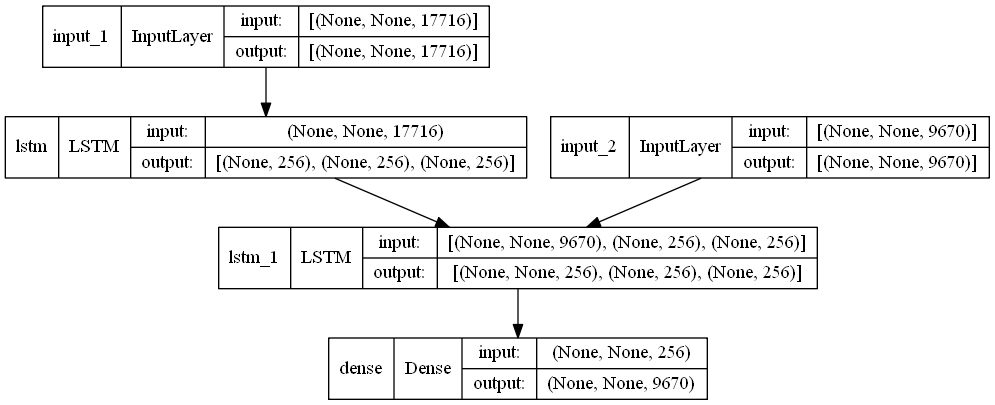

In [19]:
from keras.models import Model
from tensorflow.keras.utils import plot_model
#generate accuracy measurement
#it takes encoder and decoder input layer as an array of inputs
#and the decoder LSTM as the output

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Step 4: Train the model

In [20]:
model.compile(optimizer=" ", loss=" ", metrics=["accuracy"])


model.fit()

model.save("seq2seq")

model.summary()

ValueError: Unknown optimizer:  . Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

## Step 5: Test the model --> making predictions
Testing with input_test from ICAMET corpus and ARCHER corpus (first century 1600-1700) to see how well the model performs

**evaluation metrics** 

accuracy: compare with the number of words that don't need to be changed 

precision and recall -> for words that the algorithm changed something / gold standard cases